Agenda
- SVM(Support Vector Machine)支持向量机(线性+非线性分类器) - 核函数：线性，多项式，径向基函数RBF
- 解决数量不平衡问题
- 提取置信度
- 超参数最优化
- svm参考资料
  - http://web.mit.edu/zoya/www/SVM.pdf
  - http://www.support-vector.net/icml-tutorial.pdf
  - http://www.svms.org/tutorials/Berwick2003.pdf
- 核函数(kernel function)参考资料
  - http://www.eric-kim.net/eric-kim-net/posts/1/kernel_trick.html
- 置信度，概率度量参考资料（将距离度量转化为概率度量）
  - http://fastml.com/classifier-calibration-with-platts-scaling-and-isotonic-regression/
- 自动寻找最优超参数
- 实例：事件预测器 SVC - 预测一栋大楼进出的人数
- 实例：估算交通流量 SVR

#### SVM构建线性分类器
- 用线性核函数初始化SVM对象：params = {'kernel': 'linear'}

In [0]:
# SVM构建线性分类器
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection

# spark读取DBFS中txt文件
df = spark.read.text('/FileStore/tables/data_multivar_svm.txt')

# txt文件中所有数据会自动到dataframe中的一列
df1 = df.toPandas()

# 将txt中文本格式的数据，通过逗号来拆分开，并保留为string格式
expand_df = df1['value'].str.split(',', expand=True)

# 暴力字典法 - 批量遍历修改数据集的列名
new_dict = {key:'col'+'_'+str(i) for i, key in enumerate(expand_df.columns)}
expand_df.rename(columns=new_dict, inplace=True)

# str类型数据转化为numeric
lst_to_num = ['col_0', 'col_1', 'col_2']
for i in lst_to_num:
    expand_df[i] = pd.to_numeric(expand_df[i])
    
expand_df

print(expand_df.head())

X = np.array(expand_df.iloc[:,:-1])
y = np.array(expand_df.iloc[:,-1])

   col_0  col_1  col_2
0   5.35   4.48      0
1   6.72   5.37      0
2   3.57   5.25      0
3   4.77   7.65      1
4   2.25   4.07      1


Out[2]: Text(0.5, 1.0, 'Input data')

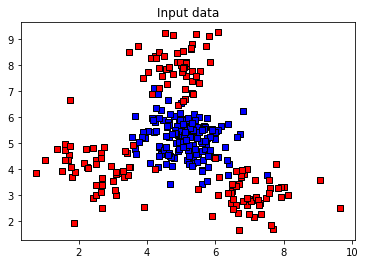

In [0]:
# 先对数据进行可视化，观察不同类别的分布情况
expand_df
class_0=[]
class_1=[]

for i in range(len(expand_df)):
    
    temp = expand_df.iloc[i,0:2].tolist()
    
    if expand_df.iloc[i,2]==0:
        class_0.append(temp)
    else:
        class_1.append(temp)

class_0 = np.array(class_0)
class_1 = np.array(class_1)

# np.vstack((a,b))[:,1]

plt.figure()
plt.scatter(class_0[:,0], class_0[:,1], facecolors='blue', edgecolors='black', marker='s')
plt.scatter(class_1[:,0], class_1[:,1], facecolors='red', edgecolors='black', marker='s')
plt.title('Input data')

In [0]:
# 分类器结果可视化的自定义函数：
# Plot the classifier boundaries on input data
def plot_classifier(classifier, X, y, title='Classifier boundaries', annotate=False):
    # define ranges to plot the figure 
    x_min, x_max = min(X[:, 0]) - 1.0, max(X[:, 0]) + 1.0
    y_min, y_max = min(X[:, 1]) - 1.0, max(X[:, 1]) + 1.0

    # denotes the step size that will be used in the mesh grid
    step_size = 0.01

    # define the mesh grid
    x_values, y_values = np.meshgrid(np.arange(x_min, x_max, step_size), np.arange(y_min, y_max, step_size))

    # compute the classifier output
    mesh_output = classifier.predict(np.c_[x_values.ravel(), y_values.ravel()])

    # reshape the array
    mesh_output = mesh_output.reshape(x_values.shape)

    # Plot the output using a colored plot 
    plt.figure()

    # Set the title
    plt.title(title)

    # choose a color scheme you can find all the options 
    # here: http://matplotlib.org/examples/color/colormaps_reference.html
    plt.pcolormesh(x_values, y_values, mesh_output, cmap=plt.cm.tab20b)

    # Overlay the training points on the plot 
    plt.scatter(X[:, 0], X[:, 1], c=y, s=80, edgecolors='black', linewidth=1, cmap=plt.cm.Dark2)

    # specify the boundaries of the figure
    plt.xlim(x_values.min(), x_values.max())
    plt.ylim(y_values.min(), y_values.max())

    # specify the ticks on the X and Y axes
    plt.xticks(())
    plt.yticks(())

    if annotate:
        for x, y in zip(X[:, 0], X[:, 1]):
            # Full documentation of the function available here: 
            # http://matplotlib.org/api/text_api.html#matplotlib.text.Annotation
            plt.annotate(
                '(' + str(round(x, 1)) + ',' + str(round(y, 1)) + ')',
                xy = (x, y), xytext = (-15, 15), 
                textcoords = 'offset points', 
                horizontalalignment = 'right', 
                verticalalignment = 'bottom', 
                bbox = dict(boxstyle = 'round,pad=0.6', fc = 'white', alpha = 0.8),
                arrowprops = dict(arrowstyle = '-', connectionstyle = 'arc3,rad=0'))

<command-3434402149756206>:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x_values, y_values, mesh_output, cmap=plt.cm.tab20b)
<command-3434402149756206>:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x_values, y_values, mesh_output, cmap=plt.cm.tab20b)


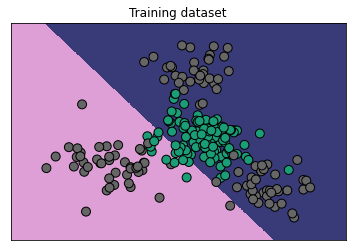

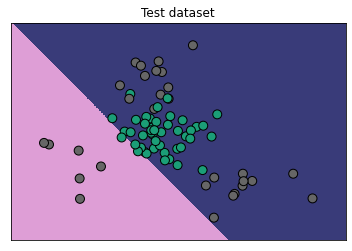

In [0]:
###############################################
# Train test split and SVM training
from sklearn import model_selection
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=5)

# 定义核函数求解器
params = {'kernel': 'linear'}
# params = {'kernel': 'poly', 'degree': 3}
# params = {'kernel': 'rbf'}

# SVC训练
classifier = SVC(**params)
classifier.fit(X_train, y_train)

# 训练结果可视化
plot_classifier(classifier, X_train, y_train, 'Training dataset')

# 测试结果可视化
y_test_pred = classifier.predict(X_test)
plot_classifier(classifier, X_test, y_test, 'Test dataset')

In [0]:
# Evaluate classifier performance - 评估分类器模型性能
from sklearn.metrics import classification_report

target_names = ['Class-' + str(int(i)) for i in set(y)]
print("\n" + "*"*60)
print("\nClassifier performance on training dataset\n")
print(classification_report(y_train, classifier.predict(X_train), target_names=target_names))
print("*"*60 + "\n")

print("*"*60)
print("\nClassification report on test dataset\n")
print(classification_report(y_test, y_test_pred, target_names=target_names))
print("*"*60 + "\n")


************************************************************

Classifier performance on training dataset

              precision    recall  f1-score   support

     Class-0       0.55      0.88      0.68       105
     Class-1       0.78      0.38      0.51       120

    accuracy                           0.61       225
   macro avg       0.66      0.63      0.59       225
weighted avg       0.67      0.61      0.59       225

************************************************************

************************************************************

Classification report on test dataset

              precision    recall  f1-score   support

     Class-0       0.64      0.96      0.77        45
     Class-1       0.75      0.20      0.32        30

    accuracy                           0.65        75
   macro avg       0.70      0.58      0.54        75
weighted avg       0.69      0.65      0.59        75

************************************************************



#### SVM构建非线性分类器
- 用多项式方程初始化SVM对象，构建曲线边界：params = {'kernel': 'poly', 'degree': 3}

<command-3434402149756206>:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x_values, y_values, mesh_output, cmap=plt.cm.tab20b)
<command-3434402149756206>:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x_values, y_values, mesh_output, cmap=plt.cm.tab20b)


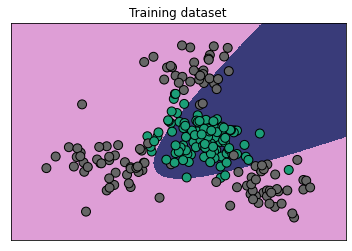

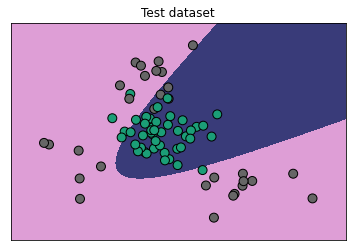

In [0]:
###############################################
# Train test split and SVM training 
from sklearn import model_selection
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=5)

# 定义核函数求解器
# params = {'kernel': 'linear'}
params = {'kernel': 'poly', 'degree': 3}
# params = {'kernel': 'rbf'}

# SVC训练
classifier = SVC(**params)
classifier.fit(X_train, y_train)

# 训练结果可视化
plot_classifier(classifier, X_train, y_train, 'Training dataset')

# 测试结果可视化
y_test_pred = classifier.predict(X_test)
plot_classifier(classifier, X_test, y_test, 'Test dataset')

In [0]:
# Evaluate classifier performance - 评估分类器模型性能
from sklearn.metrics import classification_report

target_names = ['Class-' + str(int(i)) for i in set(y)]
print("\n" + "*"*60)
print("\nClassifier performance on training dataset\n")
print(classification_report(y_train, classifier.predict(X_train), target_names=target_names))
print("*"*60 + "\n")

print("*"*60)
print("\nClassification report on test dataset\n")
print(classification_report(y_test, y_test_pred, target_names=target_names))
print("*"*60 + "\n")


************************************************************

Classifier performance on training dataset

              precision    recall  f1-score   support

     Class-0       0.92      0.84      0.88       105
     Class-1       0.87      0.93      0.90       120

    accuracy                           0.89       225
   macro avg       0.89      0.89      0.89       225
weighted avg       0.89      0.89      0.89       225

************************************************************

************************************************************

Classification report on test dataset

              precision    recall  f1-score   support

     Class-0       0.91      0.89      0.90        45
     Class-1       0.84      0.87      0.85        30

    accuracy                           0.88        75
   macro avg       0.87      0.88      0.88        75
weighted avg       0.88      0.88      0.88        75

************************************************************



#### SVM构建非线性分类器
- 用径向基函数(RBF - Radial Basis Function)来初始化SVM对象，构建曲线边界：params = {'kernel': 'rbf'}

<command-3434402149756206>:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x_values, y_values, mesh_output, cmap=plt.cm.tab20b)
<command-3434402149756206>:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x_values, y_values, mesh_output, cmap=plt.cm.tab20b)


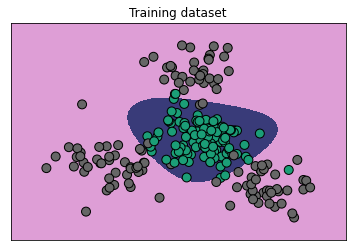

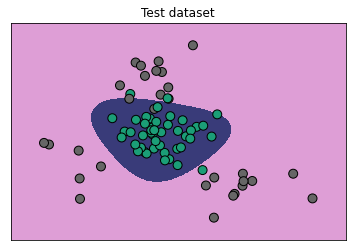

In [0]:
###############################################
# Train test split and SVM training 
from sklearn import model_selection
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=5)

# 定义核函数求解器
# params = {'kernel': 'linear'}
# params = {'kernel': 'poly', 'degree': 3}
params = {'kernel': 'rbf'}

# SVC训练
classifier = SVC(**params)
classifier.fit(X_train, y_train)

# 训练结果可视化
plot_classifier(classifier, X_train, y_train, 'Training dataset')

# 测试结果可视化
y_test_pred = classifier.predict(X_test)
plot_classifier(classifier, X_test, y_test, 'Test dataset')

In [0]:
# Evaluate classifier performance - 评估分类器模型性能
from sklearn.metrics import classification_report

target_names = ['Class-' + str(int(i)) for i in set(y)]
print("\n" + "*"*60)
print("\nClassifier performance on training dataset\n")
print(classification_report(y_train, classifier.predict(X_train), target_names=target_names))
print("*"*60 + "\n")

print("*"*60)
print("\nClassification report on test dataset\n")
print(classification_report(y_test, y_test_pred, target_names=target_names))
print("*"*60 + "\n")


************************************************************

Classifier performance on training dataset

              precision    recall  f1-score   support

     Class-0       0.95      0.96      0.96       105
     Class-1       0.97      0.96      0.96       120

    accuracy                           0.96       225
   macro avg       0.96      0.96      0.96       225
weighted avg       0.96      0.96      0.96       225

************************************************************

************************************************************

Classification report on test dataset

              precision    recall  f1-score   support

     Class-0       0.95      0.93      0.94        45
     Class-1       0.90      0.93      0.92        30

    accuracy                           0.93        75
   macro avg       0.93      0.93      0.93        75
weighted avg       0.93      0.93      0.93        75

************************************************************



#### 样本类别不均衡问题
- params{'kernel':'linear','class_weight':'auto'}

In [0]:
# SVM构建线性分类器
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection

# spark读取DBFS中txt文件
df = spark.read.text('/FileStore/tables/data_multivar_imbalance.txt')

# txt文件中所有数据会自动到dataframe中的一列
df1 = df.toPandas()

# 将txt中文本格式的数据，通过逗号来拆分开，并保留为string格式
expand_df = df1['value'].str.split(',', expand=True)

# 暴力字典法 - 批量遍历修改数据集的列名
new_dict = {key:'col'+'_'+str(i) for i, key in enumerate(expand_df.columns)}
expand_df.rename(columns=new_dict, inplace=True)

expand_df

# str类型数据转化为numeric
lst_to_num = ['col_0', 'col_1', 'col_2']
for i in lst_to_num:
    expand_df[i] = pd.to_numeric(expand_df[i])
    
expand_df

print(expand_df.head())

X = np.array(expand_df.iloc[:,:-1])
y = np.array(expand_df.iloc[:,-1])

   col_0  col_1  col_2
0   4.53   4.75      1
1   5.85   6.26      0
2   2.06   5.18      1
3   7.73   4.04      1
4   4.06   2.52      1


Out[11]: Text(0.5, 1.0, 'Input data')

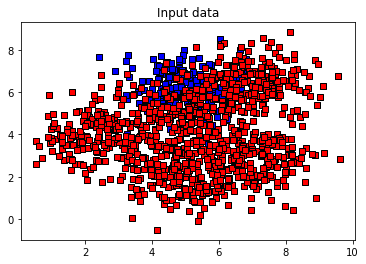

In [0]:
# 先对数据进行可视化，观察不同类别的分布情况
expand_df
class_0=[]
class_1=[]

for i in range(len(expand_df)):
    
    temp = expand_df.iloc[i,0:2].tolist()
    
    if expand_df.iloc[i,2]==0:
        class_0.append(temp)
    else:
        class_1.append(temp)

class_0 = np.array(class_0)
class_1 = np.array(class_1)

# np.vstack((a,b))[:,1]

plt.figure()
plt.scatter(class_0[:,0], class_0[:,1], facecolors='blue', edgecolors='black', marker='s')
plt.scatter(class_1[:,0], class_1[:,1], facecolors='red', edgecolors='black', marker='s')
plt.title('Input data')

<command-3434402149756206>:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x_values, y_values, mesh_output, cmap=plt.cm.tab20b)
<command-3434402149756206>:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x_values, y_values, mesh_output, cmap=plt.cm.tab20b)


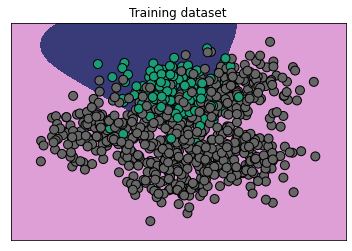

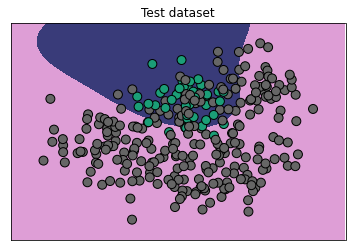

In [0]:
###############################################
# Train test split and SVM training
from sklearn import model_selection
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=5)

# 定义核函数求解器
# params = {'kernel': 'linear'}
# params = {'kernel': 'poly', 'degree': 3}
# params = {'kernel': 'rbf'}
params = {'kernel':'rbf','class_weight':'balanced'}

# SVC训练
classifier = SVC(**params)
classifier.fit(X_train, y_train)

# 训练结果可视化
plot_classifier(classifier, X_train, y_train, 'Training dataset')

# 测试结果可视化
y_test_pred = classifier.predict(X_test)
plot_classifier(classifier, X_test, y_test, 'Test dataset')

In [0]:
# Evaluate classifier performance - 评估分类器模型性能
from sklearn.metrics import classification_report

target_names = ['Class-' + str(int(i)) for i in set(y)]
print("\n" + "*"*60)
print("\nClassifier performance on training dataset\n")
print(classification_report(y_train, classifier.predict(X_train), target_names=target_names))
print("*"*60 + "\n")

print("*"*60)
print("\nClassification report on test dataset\n")
print(classification_report(y_test, y_test_pred, target_names=target_names))
print("*"*60 + "\n")


************************************************************

Classifier performance on training dataset

              precision    recall  f1-score   support

     Class-0       0.50      0.93      0.65       158
     Class-1       0.98      0.80      0.88       742

    accuracy                           0.82       900
   macro avg       0.74      0.87      0.77       900
weighted avg       0.90      0.82      0.84       900

************************************************************

************************************************************

Classification report on test dataset

              precision    recall  f1-score   support

     Class-0       0.46      0.88      0.60        42
     Class-1       0.98      0.83      0.90       258

    accuracy                           0.84       300
   macro avg       0.72      0.86      0.75       300
weighted avg       0.90      0.84      0.86       300

************************************************************



#### 提取置信度
- 输出SVM分类类别的置信度

In [0]:
# SVM构建线性分类器
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection

# spark读取DBFS中txt文件
df = spark.read.text('/FileStore/tables/data_multivar_svm.txt')

# txt文件中所有数据会自动到dataframe中的一列
df1 = df.toPandas()

# 将txt中文本格式的数据，通过逗号来拆分开，并保留为string格式
expand_df = df1['value'].str.split(',', expand=True)

# 暴力字典法 - 批量遍历修改数据集的列名
new_dict = {key:'col'+'_'+str(i) for i, key in enumerate(expand_df.columns)}
expand_df.rename(columns=new_dict, inplace=True)

# str类型数据转化为numeric
lst_to_num = ['col_0', 'col_1', 'col_2']
for i in lst_to_num:
    expand_df[i] = pd.to_numeric(expand_df[i])
    
expand_df

print(expand_df.head())

X = np.array(expand_df.iloc[:,:-1])
y = np.array(expand_df.iloc[:,-1])

   col_0  col_1  col_2
0   5.35   4.48      0
1   6.72   5.37      0
2   3.57   5.25      0
3   4.77   7.65      1
4   2.25   4.07      1


In [0]:
# 训练测试数据划分
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=5)

# 训练SVM非线性模型
params = {'kernel': 'rbf'}
classifier = SVC(**params)
classifier.fit(X_train, y_train)

# 测量数据点到边界的距离
input_datapoints = np.array([[2, 1.5], [8, 9], [4.8, 5.2], [4, 4], [2.5, 7], [7.6, 2], [5.4, 5.9]])

print("\nDistance from the boundary:")
for i in input_datapoints:
#     print(i)
    i1 = np.array(i).reshape(-1,2) # reshape(-1, x),-1表示行数自动计算
#     print(i1)
    print(i, '-->', classifier.decision_function(i1)[0])


Distance from the boundary:
[2.  1.5] --> 1.4641534796440951
[8. 9.] --> 1.2027833384010422
[4.8 5.2] --> -1.9202588134880436
[4. 4.] --> -0.13555127690004642
[2.5 7. ] --> 0.6173950571872193
[7.6 2. ] --> 2.0058455177573045
[5.4 5.9] --> -1.3395252492125262



Confidence measure:
[2.  1.5] --> [0.01509935 0.98490065]
[8. 9.] --> [0.03076573 0.96923427]
[4.8 5.2] --> [0.99476294 0.00523706]
[4. 4.] --> [0.56923461 0.43076539]
[2.5 7. ] --> [0.13948279 0.86051721]
[7.6 2. ] --> [0.00337843 0.99662157]
[5.4 5.9] --> [0.97367205 0.02632795]
<command-3434402149756206>:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x_values, y_values, mesh_output, cmap=plt.cm.tab20b)


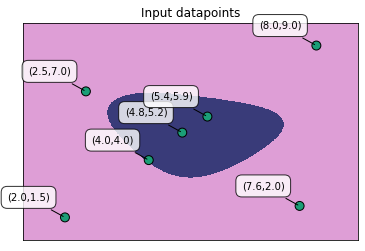

In [0]:
# 重新训练模型，增加"概率输出"的部分：
params = {'kernel': 'rbf', 'probability': True}
classifier = SVC(**params)
classifier.fit(X_train, y_train)

# 输出置信区间
print("\nConfidence measure:")
for i in input_datapoints:
    i1 = np.array(i).reshape(-1,2)
    print(i, '-->', classifier.predict_proba(i1)[0])

plot_classifier(classifier, input_datapoints, [0]*len(input_datapoints), 'Input datapoints', 'True')
# plt.show()

#### 自动寻找最优超参数
- parameter_grid
- grid_search

In [0]:
# SVM构建线性分类器
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn import svm, model_selection
from sklearn.metrics import classification_report

# spark读取DBFS中txt文件
df = spark.read.text('/FileStore/tables/data_multivar_svm.txt')

# txt文件中所有数据会自动到dataframe中的一列
df1 = df.toPandas()

# 将txt中文本格式的数据，通过逗号来拆分开，并保留为string格式
expand_df = df1['value'].str.split(',', expand=True)

# 暴力字典法 - 批量遍历修改数据集的列名
new_dict = {key:'col'+'_'+str(i) for i, key in enumerate(expand_df.columns)}
expand_df.rename(columns=new_dict, inplace=True)

# str类型数据转化为numeric
lst_to_num = ['col_0', 'col_1', 'col_2']
for i in lst_to_num:
    expand_df[i] = pd.to_numeric(expand_df[i])
    
expand_df

print(expand_df.head())

X = np.array(expand_df.iloc[:,:-1])
y = np.array(expand_df.iloc[:,-1])

   col_0  col_1  col_2
0   5.35   4.48      0
1   6.72   5.37      0
2   3.57   5.25      0
3   4.77   7.65      1
4   2.25   4.07      1


In [0]:
# Train test split

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=5)

# Set the parameters by cross-validation. 超参数说明↓
# kernel: 核函数，默认是rbf，可以是'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'
# C: SVC的惩罚参数C. 
    # C越大，相当于惩罚松弛变量，希望松弛变量接近0，即对误分类的惩罚增大，趋向于对训练集全分对的情况，这样对训练集测试时准确率很高，但泛化能力弱。
    # C值小，对误分类的惩罚减小，允许容错，将他们当成噪声点，泛化能力较强
# gamma: 'rbf','poly' 和'sigmoid'的核函数参数。默认是'auto'，则会选择1/n_features
parameter_grid = [  {'kernel': ['linear'], 'C': [1, 10, 50, 600]},
                    {'kernel': ['poly'], 'degree': [2, 3]},
                    {'kernel': ['rbf'], 'gamma': [0.01, 0.001], 'C': [1, 10, 50, 600]},
                 ]

metrics = ['precision']
# metric = ['roc_auc_ovr_weighted']
# 关于metric的定义参考：
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter


# 初始化SVC模型
for metric in metrics:
    print("\n#### Searching optimal hyperparameters for", metric)
    classifier = model_selection.GridSearchCV(svm.SVC(C=1), parameter_grid, cv=5, scoring=metric)
    classifier.fit(X_train, y_train)

# 关于GridSearchCV的定义方法：
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

# 输出最优化实验结果
print("\nScores across the parameter grid:")
print("\nHighest scoring parameter set:", classifier.best_params_)
print("\nBest score:", classifier.best_score_)
print("\nBest estimator:", classifier.best_estimator_)


#### Searching optimal hyperparameters for precision

Scores across the parameter grid:

Highest scoring parameter set: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

Best score: 0.9829710144927537

Best estimator: SVC(C=10, gamma=0.01)


In [0]:
# 输出DOE实验的所有结果：

# 输出cv_results包含的字段：
print("\nclassifier.cv_results:")
print(classifier.cv_results_.keys())

output=[]
# 定义模型性能显示结果维度 
evaluation_list = ['params', 'mean_test_score', 'rank_test_score']

for i in evaluation_list:
#     if i == 'params' or i == 'mean_test_score' or i == 'rank_test_score':
    output.append(classifier.cv_results_[i])

result = pd.DataFrame({
    'params': output[0],
    'mean_test_score': output[1],
    'rank_test_score': output[2]
})
result


classifier.cv_results:
dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_kernel', 'param_degree', 'param_gamma', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])


params 
 mean_test_score 
 rank_test_score 
 
 
 
 
 0 
 {'C': 1, 'kernel': 'linear'} 
 0.675518 
 9 
 
 
 1 
 {'C': 10, 'kernel': 'linear'} 
 0.675518 
 9 
 
 
 2 
 {'C': 50, 'kernel': 'linear'} 
 0.675518 
 9 
 
 
 3 
 {'C': 600, 'kernel': 'linear'} 
 0.675518 
 9 
 
 
 4 
 {'degree': 2, 'kernel': 'poly'} 
 0.874081 
 6 
 
 
 5 
 {'degree': 3, 'kernel': 'poly'} 
 0.871958 
 7 
 
 
 6 
 {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'} 
 0.979798 
 3 
 
 
 7 
 {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'} 
 0.533333 
 14 
 
 
 8 
 {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'} 
 0.982971 
 1 
 
 
 9 
 {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'} 
 0.543482 
 13 
 
 
 10 
 {'C': 50, 'gamma': 0.01, 'kernel': 'rbf'} 
 0.958971 
 5 
 
 
 11 
 {'C': 50, 'gamma': 0.001, 'kernel': 'rbf'} 
 0.805967 
 8 
 
 
 12 
 {'C': 600, 'gamma': 0.01, 'kernel': 'rbf'} 
 0.966638 
 4 
 
 
 13 
 {'C': 600, 'gamma': 0.001, 'kernel': 'rbf'} 
 0.982576 
 2

In [0]:
# 最后用最优超参数重新训练模型，完成模型预测
params = {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
classifier = SVC(**params)
classifier.fit(X_train, y_train)

y_true, y_pred = y_test, classifier.predict(X_test)
print("\nFull performance report:\n")
print(classification_report(y_true, y_pred))


Full performance report:

              precision    recall  f1-score   support

           0       0.92      0.98      0.95        45
           1       0.96      0.87      0.91        30

    accuracy                           0.93        75
   macro avg       0.94      0.92      0.93        75
weighted avg       0.94      0.93      0.93        75



#### 实例：预测一栋大楼实际进出的人数
- SVC
- 数据集来源：https://archive.ics.uci.edu/ml/datasets/CalIt2+Building+People+Counts

In [0]:
# SVM classifier to detect different types of events

import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.svm import SVC

In [0]:
# spark读取DBFS中txt文件
df = spark.read.text('/FileStore/tables/building_event_multiclass.txt')
# 测试二分类问题，可用building_event_binary.txt数据集来测试。

# txt文件中所有数据会自动到dataframe中的一列
df1 = df.toPandas()

# 将txt中文本格式的数据，通过逗号来拆分开，并保留为string格式
expand_df = df1['value'].str.split(',', expand=True)

# 暴力字典法 - 批量遍历修改数据集的列名
new_dict = {key:'col'+'_'+str(i) for i, key in enumerate(expand_df.columns)}
expand_df.rename(columns=new_dict, inplace=True)

# str类型数据转化为numeric
# lst_to_num = ['col_3', 'col_4']
# for i in lst_to_num:
#     expand_df[i] = pd.to_numeric(expand_df[i])
    
expand_df

print(expand_df.head())

# X = np.array(expand_df.iloc[:,:-1])
# y = np.array(expand_df.iloc[:,-1])

     col_0     col_1     col_2 col_3 col_4   col_5
0  Tuesday  07/26/05  11:30:00     9    26  eventA
1  Tuesday  07/26/05  12:00:00     8    13  eventA
2  Tuesday  07/26/05  12:30:00     6     3  eventA
3  Tuesday  07/26/05  13:00:00    25    12  eventA
4  Tuesday  07/26/05  13:30:00    12    12  eventA


In [0]:
X=np.array(expand_df)

# Convert string data to numerical data
label_encoder = [] 
X_encoded = np.empty(X.shape)
for i,item in enumerate(X[0]):
    if type(item) is not str:
        X_encoded[:, i] = X[:, i]
    else:
        label_encoder.append(preprocessing.LabelEncoder())
        X_encoded[:, i] = label_encoder[-1].fit_transform(X[:, i])
        
X_encoded

Out[109]: array([[ 4.,  0.,  6., 37., 18.,  0.],
       [ 4.,  0.,  7., 36.,  4.,  0.],
       [ 4.,  0.,  8., 34., 21.,  0.],
       ...,
       [ 1., 26., 23.,  4., 30.,  2.],
       [ 1., 26., 24., 19.,  3.,  2.],
       [ 1., 26., 25., 10., 11.,  2.]])

In [0]:
X = X_encoded[:, :-1].astype(int)
y = X_encoded[:, -1].astype(int)

# Build SVM
params = {'kernel': 'rbf', 'probability': True, 'class_weight': 'balanced'} 
classifier = SVC(**params)
classifier.fit(X, y)

# Cross validation
from sklearn import model_selection

accuracy = model_selection.cross_val_score(classifier, X, y, scoring='accuracy', cv=3)
print("Accuracy of the classifier: " + str(round(100*accuracy.mean(), 2)) + "%")

Accuracy of the classifier: 62.37%


In [0]:
# Testing encoding on single data instance
input_data = np.array(np.array(expand_df.iloc[0:2,:-1]))
input_data_encoded = np.empty(input_data.shape)
count = 0

for i,item in enumerate(input_data[0]):
#     print(item)
#     print(type(item))
    
    if type(item) is not str:
        input_data_encoded[:,i] = input_data[:,i]
    else:
#         input_data_encoded[i] = int(label_encoder[count].transform(input_data[i]))
        input_data_encoded[:,i] = (label_encoder[count].transform(input_data[:,i]))
        count = count + 1 

input_data_encoded = np.array(input_data_encoded)

# Predict and print output for a particular datapoint
output_class = classifier.predict(input_data_encoded)
print("Output class:", label_encoder[-1].inverse_transform(output_class)[0])

Output class: eventA


#### 实例：估算交通流量
- SVR
- 数据源：https://archive.ics.uci.edu/ml/datasets/Dodgers+Loop+Sensor. 数据集统计了棒球队主场比赛期间，体育场周边马路通过的车辆数量

In [0]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.svm import SVR

In [0]:
# spark读取DBFS中txt文件
df = spark.read.text('/FileStore/tables/traffic_data.txt')
# 测试二分类问题，可用building_event_binary.txt数据集来测试。

# txt文件中所有数据会自动到dataframe中的一列
df1 = df.toPandas()

# 将txt中文本格式的数据，通过逗号来拆分开，并保留为string格式
expand_df = df1['value'].str.split(',', expand=True)

# 暴力字典法 - 批量遍历修改数据集的列名
new_dict = {key:'col'+'_'+str(i) for i, key in enumerate(expand_df.columns)}
expand_df.rename(columns=new_dict, inplace=True)

# str类型数据转化为numeric
lst_to_num = ['col_4']
for i in lst_to_num:
    expand_df[i] = pd.to_numeric(expand_df[i])
    
expand_df

print(expand_df.head())

# X = np.array(expand_df.iloc[:,:-1])
# y = np.array(expand_df.iloc[:,-1])

     col_0  col_1          col_2 col_3  col_4
0  Tuesday  00:00  San Francisco    no      3
1  Tuesday  00:05  San Francisco    no      8
2  Tuesday  00:10  San Francisco    no     10
3  Tuesday  00:15  San Francisco    no      6
4  Tuesday  00:20  San Francisco    no      1


In [0]:
X = np.array(expand_df)


# Convert string data to numerical data
label_encoder = [] 
X_encoded = np.empty(X.shape)
for i,item in enumerate(X[0]):
    if type(item) is not str:
        X_encoded[:, i] = X[:, i]
    else:
        label_encoder.append(preprocessing.LabelEncoder())
        X_encoded[:, i] = label_encoder[-1].fit_transform(X[:, i])

X = X_encoded[:, :-1].astype(int)
y = X_encoded[:, -1].astype(int)


# Build SVR
params = {'kernel': 'rbf', 'C': 10.0, 'epsilon': 0.2} 
regressor = SVR(**params)
regressor.fit(X, y)


# Cross validation
import sklearn.metrics as sm
y_pred = regressor.predict(X)
print("Mean absolute error =", round(sm.mean_absolute_error(y, y_pred), 2))

Mean absolute error = 7.28


In [0]:
# Testing encoding on single data instance
input_data = np.array(np.array(expand_df.iloc[0:2,:-1]))
print('\nInput_data:\n',input_data)

input_data_encoded = np.empty(input_data.shape)
count = 0

for i,item in enumerate(input_data[0]):
#     print(item)
#     print(type(item))
    
    if type(item) is not str:
        input_data_encoded[:,i] = input_data[:,i]
    else:
#         input_data_encoded[i] = int(label_encoder[count].transform(input_data[i]))
        input_data_encoded[:,i] = (label_encoder[count].transform(input_data[:,i]))
        count = count + 1 

input_data_encoded = np.array(input_data_encoded)

# Predict and print output for a particular datapoint
# output_class = classifier.predict(input_data_encoded)
# print("\nPredicted traffic:", label_encoder[-1].inverse_transform(output_class)[0])
print("Predicted traffic:\n", regressor.predict(input_data_encoded))
print("Predicted traffic:\n", regressor.predict(input_data_encoded).astype(int))


Input_data:
 [['Tuesday' '00:00' 'San Francisco' 'no']
 ['Tuesday' '00:05' 'San Francisco' 'no']]
Predicted traffic:
 [8.47826601 8.0323291 ]
Predicted traffic:
 [8 8]
